# Fighting fire with firepower
## Part 3: Optimizing parameters for our neural network
<br>
<br>

> Wayne Chan <br>
> Mariam Javed <br>
> Shawn Syms 

<a name="contents"></a>
## Contents

- [Imports](#Imports)
- [Preprocessing](#Preprocessing)
- [Feature engineering](#Feature-engineering)
- [Neural Network: Feed Forward](#Neural-Network:-Feed-Forward)

## Imports

In [ ]:
import datetime
import numpy as np
import pandas as pd

# presentation and visualization
import seaborn as sns
import matplotlib.pyplot as plt

# keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import utils


# sci-kit learn 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

<div style="text-align: right">(<a href="#contents">home</a>) </div>

## Preprocessing

In [ ]:
# Read in the data 

df = pd.read_csv('fire_size_class.csv')

In [3]:
# Adjust column name case

df.columns = map(str.lower, df.columns)

In [ ]:
# Eliminate artefact of csv import

df.drop('unnamed: 0', axis = 1, inplace = True)

In [ ]:
# let's combine all of the date columns into a single date column
df['datetime'] = df['fire_year'].astype(str) + df['discovery_doy'].astype(str)

new_list = []

for i in df['datetime']:
    
    dt = datetime.datetime.strptime(i, '%Y%j').strftime('%d/%m/%Y')
    new_list.append(dt)
    
df['dmy'] = new_list

In [ ]:
# Reorder columns

cols = df.columns.tolist()
cols = ['fire_year', 'discovery_date', 'discovery_doy', 'discovery_time', 'datetime', 'dmy',
       'stat_cause_descr', 'latitude', 'longitude', 'state', 'fire_code',
       'fire_size', 'fire_size_class']
df = df[cols]

# Rename dmy and stat_cause_descr columns

df.rename(columns={'dmy': 'fire_date', 'stat_cause_descr': 'fire_cause'}, inplace = True)

We can see that 1,555,741 values in the fire_code are null - let's drop the fire_code column as this means that it's not very helpful.

In [ ]:
# Drop fire_code column

df.drop('fire_code', axis = 1, inplace = True)

Our target is the fire_size_class - based on the value counts we can see that class 'G' has the fewest occurrences. Based on the data dictionary we know that: 
 - A=greater than 0 but less than or equal to 0.25 acres
 - B=0.26-9.9 acres
 - C=10.0-99.9 acres
 - D=100-299 acres 
 - E=300 to 999 acres
 - F=1000 to 4999 acres, and 
 - G=5000+ acres)
 
 It makes sense that G has the fewest occurrences as these are the most catastrophic fire occurrences and therefore don't occurr often. A and B being the smallest fire size classes are much more common

Let's create a function for label encoding and apply it to the df:

In [12]:
# Create function for label_encoding 

def label_encoding(df, col_name):
    le = LabelEncoder()
    df[col_name] = le.fit_transform(df[col_name])
    return df.head()

label_encoding(df, 'fire_cause')
label_encoding(df, 'fire_size_class')

fire_year  discovery_date  discovery_doy  discovery_time datetime  \
0       2005       2453403.5             33          1300.0   200533   
1       2004       2453137.5            133           845.0  2004133   
2       2004       2453156.5            152          1921.0  2004152   
3       2004       2453184.5            180          1600.0  2004180   
4       2004       2453184.5            180          1600.0  2004180   

    fire_date  fire_cause   latitude   longitude state  fire_size  \
0  02/02/2005           7  40.036944 -121.005833    CA       0.10   
1  12/05/2004           6  38.933056 -120.404444    CA       0.25   
2  31/05/2004           3  38.984167 -120.735556    CA       0.10   
3  28/06/2004           6  38.559167 -119.913333    CA       0.10   
4  28/06/2004           6  38.559167 -119.933056    CA       0.10   

   fire_size_class  
0                0  
1                0  
2                0  
3                0  
4                0

Let's drop the fire_size column because it's directly correlated to the fire_size_class column:

In [13]:
df.drop('fire_size', axis = 1, inplace = True)

<div style="text-align: right">(<a href="#contents">home</a>) </div>

## Feature engineering

In [ ]:
# since long and lat or normally used together; let's create a new column that combines those 2

df['longlat'] = df['longitude'] * df['latitude']

# we know that the time of year and the location play a role in fires:
df['timelocation'] = df['longlat'] * df['discovery_time'] * df['discovery_date']

In [ ]:
df['cause_timelocation'] = df['fire_cause'] * df['timelocation']

In [ ]:
df['doy_time_location'] = df['discovery_doy'] * df['timelocation']

Let's also create some polynomial features:

In [21]:
# Create polynomial features
# Removed year and date from polynomial features
features = ['fire_year', 'discovery_date', 'discovery_doy',
       'datetime','fire_cause', 'latitude', 'longitude', 'longlat']

X = df[features]
y = df['fire_size_class']

In [22]:
poly = PolynomialFeatures(include_bias = False)
X_poly = poly.fit_transform(X)

df = pd.DataFrame(data = X_poly, columns = poly.get_feature_names(features))
#add target back in
df['fire_size_class'] = y

## Modeling

In [28]:
# Set features and target variables

X = df.drop(['fire_size_class'], axis = 1)
y = df['fire_size_class']

In [29]:
# Set up our train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

Our baseline estimator:

In [30]:
y_test.value_counts(normalize = True)

1    0.499544
0    0.354657
2    0.117032
3    0.015119
4    0.007501
5    0.004140
6    0.002007
Name: fire_size_class, dtype: float64

In [31]:
df.shape

(1880465, 45)

<div style="text-align: right">(<a href="#contents">home</a>) </div>

Let's train another Neural Network, seeing if optimizing its parameters will improve performance. 

### Neural Network: Feed Forward

In [33]:
# Configure the labels as the array that Keras expects
y_train = utils.to_categorical(y_train, 7)
y_test = utils.to_categorical(y_test, 7)

In [36]:
# Implement standard scaling
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# Establish network topology
model = Sequential()
model.add(Dense(256, input_shape = (44,), activation = 'relu'))
model.add(Dropout(0.5)) #can add drop out here
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5)) #can add drop out here
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5)) #can add drop out here
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5)) #can add drop out here
model.add(Dense(7, activation = 'softmax'))

# Compile NN model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               11520     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [38]:
# Early stopping
# Patience tells the model how many epochs to be looking for to see improvement
# Min delta is a threshold, so WHATEVER loss or increase that occurrs is an improvement

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, min_delta = 0, restore_best_weights = True) 

#fit the model

history = model.fit(X_train_sc, y_train, validation_data = (X_test_sc, y_test), epochs = 500, batch_size = 1024)

Instructions for updating:
Use tf.cast instead.
Train on 1504372 samples, validate on 376093 samples
Epoch 1/500
1504372/1504372 [==============================] - 50s 33us/step - loss: 1.0552 - accuracy: 0.5753 - val_loss: 0.9834 - val_accuracy: 0.5988
Epoch 2/500
1504372/1504372 [==============================] - 46s 31us/step - loss: 1.0009 - accuracy: 0.5941 - val_loss: 0.9730 - val_accuracy: 0.6011
Epoch 3/500
1504372/1504372 [==============================] - 48s 32us/step - loss: 0.9891 - accuracy: 0.5978 - val_loss: 0.9639 - val_accuracy: 0.6049
Epoch 4/500
1504372/1504372 [==============================] - 47s 31us/step - loss: 0.9824 - accuracy: 0.6001 - val_loss: 0.9596 - val_accuracy: 0.6076
Epoch 5/500
1504372/1504372 [==============================] - 49s 33us/step - loss: 0.9784 - accuracy: 0.6013 - val_loss: 0.9571 - val_accuracy: 0.6088
Epoch 6/500
1504372/1504372 [==============================] - 49s 32us/step - loss: 0.9754 - accuracy: 0.6023 - val_loss: 0.9555 - va

1504372/1504372 [==============================] - 34s 23us/step - loss: 0.9510 - accuracy: 0.6101 - val_loss: 0.9286 - val_accuracy: 0.6166
Epoch 106/500
1504372/1504372 [==============================] - 33s 22us/step - loss: 0.9519 - accuracy: 0.6096 - val_loss: 0.9301 - val_accuracy: 0.6171
Epoch 107/500
1504372/1504372 [==============================] - 33s 22us/step - loss: 0.9514 - accuracy: 0.6103 - val_loss: 0.9284 - val_accuracy: 0.6173
Epoch 108/500
1504372/1504372 [==============================] - 33s 22us/step - loss: 0.9518 - accuracy: 0.6100 - val_loss: 0.9287 - val_accuracy: 0.6163
Epoch 109/500
1504372/1504372 [==============================] - 33s 22us/step - loss: 0.9516 - accuracy: 0.6102 - val_loss: 0.9288 - val_accuracy: 0.6173
Epoch 110/500
1504372/1504372 [==============================] - 33s 22us/step - loss: 0.9512 - accuracy: 0.6099 - val_loss: 0.9293 - val_accuracy: 0.6170
Epoch 111/500
1504372/1504372 [==============================] - 33s 22us/step - los

1504372/1504372 [==============================] - 36s 24us/step - loss: 0.9502 - accuracy: 0.6103 - val_loss: 0.9254 - val_accuracy: 0.6173
Epoch 210/500
1504372/1504372 [==============================] - 34s 22us/step - loss: 0.9501 - accuracy: 0.6106 - val_loss: 0.9267 - val_accuracy: 0.6177
Epoch 211/500
1504372/1504372 [==============================] - 35s 24us/step - loss: 0.9497 - accuracy: 0.6106 - val_loss: 0.9279 - val_accuracy: 0.6183
Epoch 212/500
1504372/1504372 [==============================] - 36s 24us/step - loss: 0.9501 - accuracy: 0.6107 - val_loss: 0.9278 - val_accuracy: 0.6178
Epoch 213/500
1504372/1504372 [==============================] - 36s 24us/step - loss: 0.9497 - accuracy: 0.6104 - val_loss: 0.9265 - val_accuracy: 0.6179
Epoch 214/500
1504372/1504372 [==============================] - 36s 24us/step - loss: 0.9501 - accuracy: 0.6106 - val_loss: 0.9257 - val_accuracy: 0.6176
Epoch 215/500
1504372/1504372 [==============================] - 36s 24us/step - los

Epoch 262/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9498 - accuracy: 0.6103 - val_loss: 0.9261 - val_accuracy: 0.6177
Epoch 263/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9498 - accuracy: 0.6108 - val_loss: 0.9256 - val_accuracy: 0.6179
Epoch 264/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9497 - accuracy: 0.6109 - val_loss: 0.9256 - val_accuracy: 0.6184
Epoch 265/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9502 - accuracy: 0.6102 - val_loss: 0.9264 - val_accuracy: 0.6181
Epoch 266/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9498 - accuracy: 0.6105 - val_loss: 0.9258 - val_accuracy: 0.6171
Epoch 267/500
1504372/1504372 [==============================] - 34s 23us/step - loss: 0.9498 - accuracy: 0.6103 - val_loss: 0.9283 - val_accuracy: 0.6183
Epoch 268/500
1504372/1504372 [==============================] - 34s 2

Epoch 315/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9498 - accuracy: 0.6106 - val_loss: 0.9258 - val_accuracy: 0.6182
Epoch 316/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9494 - accuracy: 0.6107 - val_loss: 0.9269 - val_accuracy: 0.6171
Epoch 317/500
1504372/1504372 [==============================] - 34s 23us/step - loss: 0.9494 - accuracy: 0.6106 - val_loss: 0.9258 - val_accuracy: 0.6177
Epoch 318/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9499 - accuracy: 0.6103 - val_loss: 0.9250 - val_accuracy: 0.6183
Epoch 319/500
1504372/1504372 [==============================] - 36s 24us/step - loss: 0.9496 - accuracy: 0.6105 - val_loss: 0.9264 - val_accuracy: 0.6174
Epoch 320/500
1504372/1504372 [==============================] - 36s 24us/step - loss: 0.9499 - accuracy: 0.6106 - val_loss: 0.9268 - val_accuracy: 0.6177
Epoch 321/500
1504372/1504372 [==============================] - 36s 2

Epoch 368/500
1504372/1504372 [==============================] - 34s 23us/step - loss: 0.9496 - accuracy: 0.6107 - val_loss: 0.9268 - val_accuracy: 0.6181
Epoch 369/500
1504372/1504372 [==============================] - 34s 23us/step - loss: 0.9497 - accuracy: 0.6105 - val_loss: 0.9248 - val_accuracy: 0.6180
Epoch 370/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9500 - accuracy: 0.6103 - val_loss: 0.9260 - val_accuracy: 0.6182
Epoch 371/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9495 - accuracy: 0.6110 - val_loss: 0.9240 - val_accuracy: 0.6176
Epoch 372/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9498 - accuracy: 0.6106 - val_loss: 0.9266 - val_accuracy: 0.6177
Epoch 373/500
1504372/1504372 [==============================] - 35s 23us/step - loss: 0.9498 - accuracy: 0.6104 - val_loss: 0.9275 - val_accuracy: 0.6173
Epoch 374/500
1504372/1504372 [==============================] - 35s 2

Epoch 473/500
1504372/1504372 [==============================] - 34s 22us/step - loss: 0.9501 - accuracy: 0.6102 - val_loss: 0.9269 - val_accuracy: 0.6181
Epoch 474/500
1504372/1504372 [==============================] - 33s 22us/step - loss: 0.9500 - accuracy: 0.6105 - val_loss: 0.9254 - val_accuracy: 0.6178
Epoch 475/500
1504372/1504372 [==============================] - 34s 23us/step - loss: 0.9500 - accuracy: 0.6105 - val_loss: 0.9250 - val_accuracy: 0.6183
Epoch 476/500
1504372/1504372 [==============================] - 34s 23us/step - loss: 0.9501 - accuracy: 0.6105 - val_loss: 0.9253 - val_accuracy: 0.6178
Epoch 477/500
1504372/1504372 [==============================] - 34s 22us/step - loss: 0.9503 - accuracy: 0.6103 - val_loss: 0.9262 - val_accuracy: 0.6187
Epoch 478/500
1504372/1504372 [==============================] - 34s 23us/step - loss: 0.9503 - accuracy: 0.6105 - val_loss: 0.9252 - val_accuracy: 0.6176
Epoch 479/500
1504372/1504372 [==============================] - 33s 2

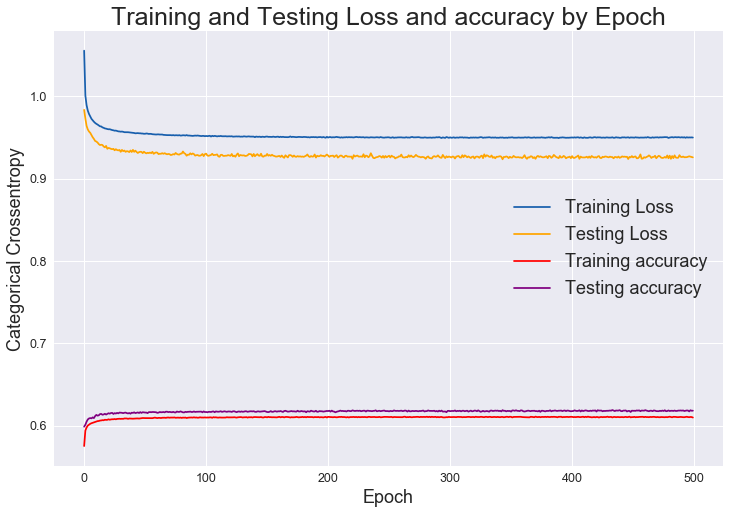

In [39]:
# Check out our train loss and test loss over epochs.

train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Set figure size

plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Generate line plot of training, testing loss over epochs

plt.plot(train_accuracy, label='Training accuracy', color='red')
plt.plot(test_accuracy, label='Testing accuracy', color='purple')

# Set title

plt.title('Training and Testing Loss and accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

<div style="text-align: right">(<a href="#contents">home</a>) </div>